# Convoluntional Variational AutoEncoder
Reference: https://keras.io/examples/generative/vae/

My idea for generating new data samples labelled as Normal and Tumor is to train a VAE which can generate a Normal sample when given a Normal test sample and a Tumor sample when given a Tumor test sample.

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Create a sampling layer


In [15]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon



## Build the encoder


In [62]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28 * 28, 1))
x = layers.Conv1D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv1D(16, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 784, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 392, 32)      128         input_21[0][0]                   
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 196, 16)      1552        conv1d_10[0][0]                  
__________________________________________________________________________________________________
flatten_7 (Flatten)             (None, 3136)         0           conv1d_11[0][0]                  
____________________________________________________________________________________________

## Build the decoder


In [110]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64 * 4, activation="relu")(latent_inputs)
x = layers.Reshape((7 * 7 * 4, 64))(x)
x = layers.Conv1DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv1DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv1DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_49 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_50 (Dense)             (None, 12544)             37632     
_________________________________________________________________
reshape_47 (Reshape)         (None, 196, 64)           0         
_________________________________________________________________
conv1d_transpose_78 (Conv1DT (None, 392, 64)           12352     
_________________________________________________________________
conv1d_transpose_79 (Conv1DT (None, 784, 32)           6176      
_________________________________________________________________
conv1d_transpose_80 (Conv1DT (None, 784, 1)            97        
Total params: 56,257
Trainable params: 56,257
Non-trainable params: 0
_______________________________________________________

## Define the VAE as a `Model` with a custom `train_step`


In [69]:

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }



## Train the VAE


In [16]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [ ]:
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

In [42]:
mnist_digits = mnist_digits.reshape(70000, 28 * 28, 1)

In [106]:


vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=3, batch_size=128)


Epoch 1/3
547/547 [==============================] - 33s 60ms/step - loss: 191.4827 - reconstruction_loss: 187.7880 - kl_loss: 3.6946
Epoch 2/3
547/547 [==============================] - 33s 60ms/step - loss: 163.2665 - reconstruction_loss: 160.1266 - kl_loss: 3.1400
Epoch 3/3
547/547 [==============================] - 32s 59ms/step - loss: 159.9586 - reconstruction_loss: 156.7490 - kl_loss: 3.2096


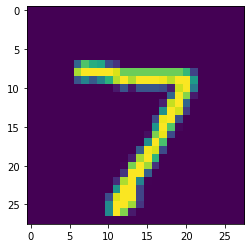

In [78]:
plt.imshow(x_test[0])

In [17]:
y_test[0]

7

In [107]:
tmp = encoder.predict(x_test[0].reshape(1, 28 * 28, 1))

In [111]:
temp = decoder.predict(tmp)

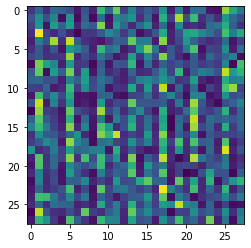

In [112]:
plt.imshow(temp.reshape(28, 28))

In [ ]:
mean, logvar = model.encode(test_sample)


In [ ]:
z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)

In [20]:
decoder.predict()

ValueError: in user code:

    /scratch/ruolinzheng/conda/envs/py38/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1462 predict_function  *
        return step_function(self, iterator)
    /scratch/ruolinzheng/conda/envs/py38/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /scratch/ruolinzheng/conda/envs/py38/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /scratch/ruolinzheng/conda/envs/py38/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /scratch/ruolinzheng/conda/envs/py38/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /scratch/ruolinzheng/conda/envs/py38/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1445 run_step  **
        outputs = model.predict_step(data)
    /scratch/ruolinzheng/conda/envs/py38/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1418 predict_step
        return self(x, training=False)
    /scratch/ruolinzheng/conda/envs/py38/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /scratch/ruolinzheng/conda/envs/py38/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:385 call
        return self._run_internal_graph(
    /scratch/ruolinzheng/conda/envs/py38/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /scratch/ruolinzheng/conda/envs/py38/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    /scratch/ruolinzheng/conda/envs/py38/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:212 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer dense_1 is incompatible with the layer: expected axis -1 of input shape to have value 2 but received input with shape [None, 28, 28]


## Display a grid of sampled digits


ValueError: The number of FixedLocator locations (31), usually from a call to set_ticks, does not match the number of ticklabels (30).

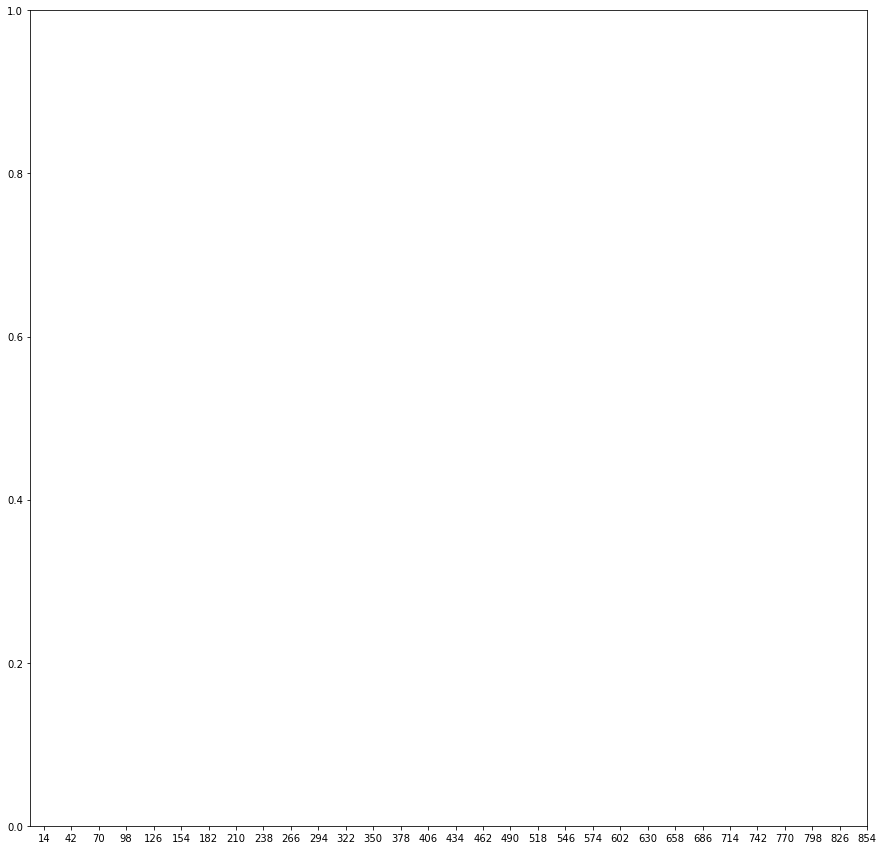

In [12]:
import matplotlib.pyplot as plt


def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder)


## Display how the latent space clusters different digit classes


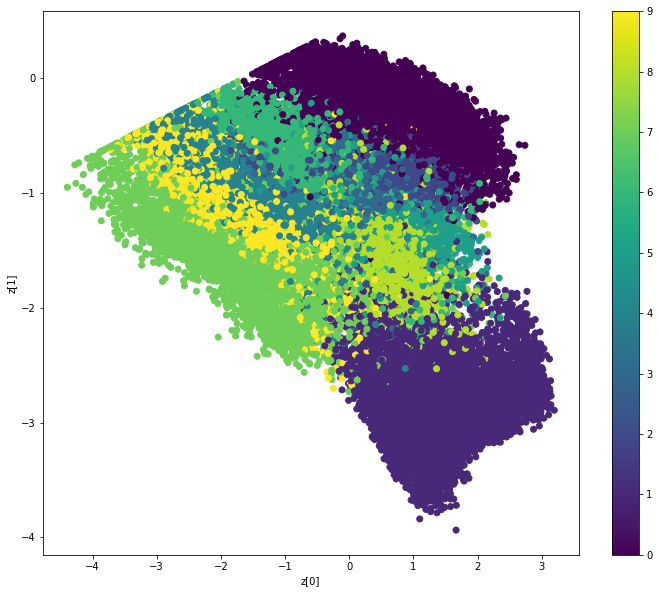

In [13]:

def plot_label_clusters(encoder, decoder, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(encoder, decoder, x_train, y_train)
